In [14]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler # Important for Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

In [15]:
print("--- Loading Pre-processed Feature Data ---")
wallet_features = pd.read_pickle('../processed_data/wallet_features.pkl')

--- Loading Pre-processed Feature Data ---


In [16]:
print("\n--- Creating Labels based on 'Liquidity Provision' Strategy ---")
model_data = wallet_features.copy()
good_wallet_criteria = (model_data['net_deposit_usd'] > 1000) & (model_data['wallet_age_days'] > 30)
bad_wallet_criteria = (model_data['net_deposit_usd'] < -1000) & (model_data['repay_borrow_ratio_usd'] < 0.9)
model_data['label'] = np.nan
model_data.loc[good_wallet_criteria, 'label'] = 1
model_data.loc[bad_wallet_criteria, 'label'] = 0
training_data = model_data.dropna(subset=['label'])
print(f"Labeled Data Stats:\n{training_data['label'].value_counts()}\n")


--- Creating Labels based on 'Liquidity Provision' Strategy ---
Labeled Data Stats:
label
0.0    6741
1.0    2039
Name: count, dtype: int64



In [17]:
leaky_features = ['net_deposit_usd', 'wallet_age_days', 'repay_borrow_ratio_usd']
features_to_use = [col for col in wallet_features.columns if col not in leaky_features]

X = training_data[features_to_use]
y = training_data['label']

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [20]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "LightGBM": lgb.LGBMClassifier(random_state=42, is_unbalance=True) # or class_weight='balanced'
}


--- Training Logistic Regression ---
Logistic Regression ROC AUC Score: 0.8402

--- Training Random Forest ---
Random Forest ROC AUC Score: 0.9867

--- Training LightGBM ---
[LightGBM] [Info] Number of positive: 1427, number of negative: 4719
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1751
[LightGBM] [Info] Number of data points in the train set: 6146, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232184 -> initscore=-1.196023
[LightGBM] [Info] Start training from score -1.196023
LightGBM ROC AUC Score: 0.9991


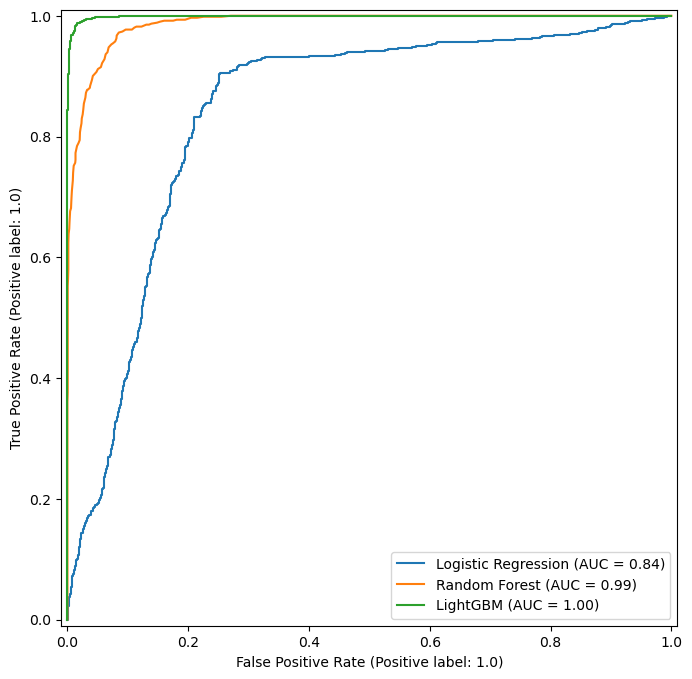

In [21]:
results = {}
plt.figure(figsize=(10, 8))
ax = plt.gca()

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    
    # Use scaled data for Logistic Regression, original for others
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        RocCurveDisplay.from_estimator(model, X_val_scaled, y_val, name=name, ax=ax)
    else:
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        RocCurveDisplay.from_estimator(model, X_val, y_val, name=name, ax=ax)
        
    auc_score = roc_auc_score(y_val, y_pred_proba)
    results[name] = auc_score
    print(f"{name} ROC AUC Score: {auc_score:.4f}")

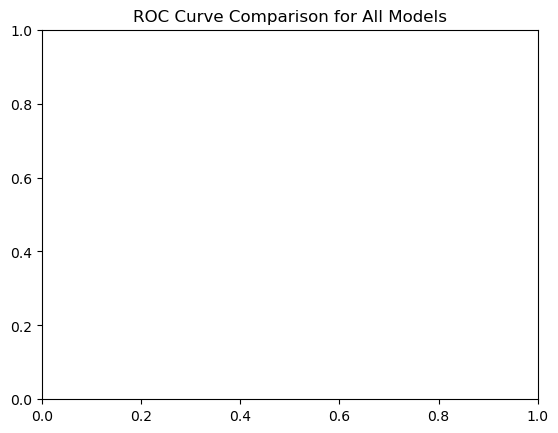


--- Model Comparison Summary ---
- Logistic Regression: AUC = 0.8402
- Random Forest: AUC = 0.9867
- LightGBM: AUC = 0.9991

WINNER: 'LightGBM' is the best performing model.

--- Generating Final Scores using LightGBM ---
Credit scores generated successfully!


In [22]:
plt.title('ROC Curve Comparison for All Models')
plt.show()

print("\n--- Model Comparison Summary ---")
best_model_name = max(results, key=results.get)
for name, score in results.items():
    print(f"- {name}: AUC = {score:.4f}")
print(f"\nWINNER: '{best_model_name}' is the best performing model.")

best_model = models[best_model_name]

# --- 4f. Generate Final Scores using the BEST Model ---
print(f"\n--- Generating Final Scores using {best_model_name} ---")

# Use the full dataset for prediction
X_all = model_data[features_to_use]

# Scale the full dataset if the best model is Logistic Regression
if best_model_name == "Logistic Regression":
    X_all_scaled = scaler.transform(X_all)
    final_probabilities = best_model.predict_proba(X_all_scaled)[:, 1]
else:
    final_probabilities = best_model.predict_proba(X_all)[:, 1]

model_data['credit_score'] = (final_probabilities * 100).round(2)
print("Credit scores generated successfully!")